# Base Import

In [ ]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

In [2]:
import os
from google.colab import drive
from google.colab import files
import torch.nn as nn
#import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np 
from IPython.display import clear_output
from IPython.display import HTML
from tensorflow.keras.utils import array_to_img
import tarfile
import argparse
import random
from PIL import Image
drive.mount("/content/gdrive", force_remount=True)
#os.chdir("/content/gdrive/My Drive/Colab Notebooks/rose")
cwd = os.getcwd()
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)


Mounted at /content/gdrive
Random Seed:  999


In [ ]:
image_type="roses"
image_size=64
os.mkdir("/content/data")
os.mkdir("/content/data/img_ds")

if image_type=="roses":
    if image_size==64:
        !cp /content/gdrive/MyDrive/DataML/Rose/rose_ds_clr_64.zip /content/data/img_ds
        !unzip -q /content/data/img_ds/rose_ds_clr_64.zip -d /content/data/img_ds
        !rm /content/data/img_ds/rose_ds_clr_64.zip
    if image_size==128:
        # INSERT LINK
        print("no link")
if image_type=="pokemon":
    if image_size==64:
        # INSERT LINK
        print("no link")
    if image_size==128:
        # INSERT LINK
        print("no link")


# Parameters

In [4]:
dataroot = "/content/data/"
# Number of workers for dataloader
workers = 4
# Batch size during training
batch_size = 32
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 16
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Dataset Creation

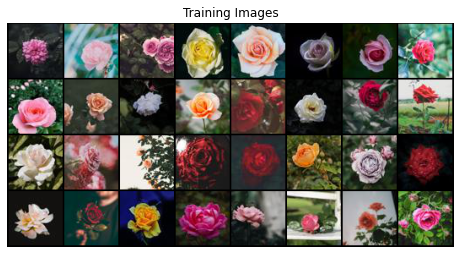

In [5]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers,pin_memory=True)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


# Model

In [6]:
class MinibatchDiscrimination2d(nn.Module):
    def __init__(self,in_size, in_flt,out_flt,intermediate_features=16):
      super(MinibatchDiscrimination2d, self).__init__()
      self.in_flt = in_flt
      self.out_flt = out_flt
      self.intermediate_features = intermediate_features

      self.conv2d= nn.Conv2d(in_flt, 3, 4, 4, 0, bias=False).cuda() #out of conv -> 3 channels, 4x4 kernel, no pad, stride 4
      self.conv2dt= nn.ConvTranspose2d(out_flt, out_flt, 4, 4, 0, bias=False).cuda()

      self.t=int((in_size-4)/4)+1
      self.T = nn.Parameter( 
          torch.Tensor(3*self.t*self.t, out_flt*self.t*self.t, self.intermediate_features)
        )
    def forward(self, x):
        x_r=self.conv2d(x) #in 32x3x32x32 -> 32x3x8x8
        #print(self.T.view(3*self.t*self.t, -1).shape) #3*8*8,2048
        M = torch.mm(x_r.view(-1,3*self.t*self.t), self.T.view(3*self.t*self.t, -1))#32x2048 =32 x 2*8*8*16 
        M = M.view(-1, self.out_flt*self.t*self.t, self.intermediate_features).unsqueeze(0)
        M_t = M.permute(1, 0, 2, 3)
        out = torch.sum(torch.exp(-(torch.abs(M - M_t).sum(3))), dim=0) - 1
        out = out.view(-1,self.out_flt,self.t,self.t)
        out_a = self.conv2dt(out)
        return torch.cat([x, out_a], 1)

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
        
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            MinibatchDiscrimination2d(32,ndf,2),
            nn.Conv2d(ndf+2, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
from Models import dc_gan64 as model
from Trainings import training_classic as trainer

In [6]:
# Create the generator
netG = model.Generator(nz,nc,ngf).cuda()
netG.apply(model.weights_init)
#print(netG)

# Create the Discriminator
netD = model.Discriminator(nc,ndf).cuda()
netD.apply(model.weights_init)

a


# Training

In [9]:
# def BCEsmooth(input,target):
#   target_ls= target*(1-0.1)+0.1/2
#   criterion = torch.nn.BCELoss().cuda()
#   return criterion(input,target_ls)

# def Normalization(fake):
#   for i in range(0,3):
#       fake[i]=(fake[i]-fake[i].min())/(fake[i].max()-fake[i].min())
#   return fake

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
img_list,G_losses,D_losses=trainer.train(dataloader,netD,netG,optimizerD,optimizerG,200,device,True,"/content/net/","/content/results/",fixed_noise)

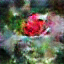

[203/1000][0/37]	Loss_D: 0.4398	Loss_G: 3.1809	D(x): 0.9275	D(G(z)): 0.0903 / 0.0439
[203/1000][25/37]	Loss_D: 0.4689	Loss_G: 2.5315	D(x): 0.9255	D(G(z)): 0.0691 / 0.0908
[204/1000][0/37]	Loss_D: 1.3114	Loss_G: 9.9180	D(x): 0.9828	D(G(z)): 0.5051 / 0.0003


KeyboardInterrupt: ignored

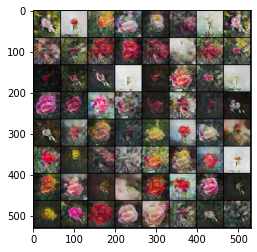

In [10]:
def training_classic_monitor(dataloader,netD,netG,optimizerD,optimizerG,num_epochs):
  # Lists to keep track of progress
  img_list = []
  G_losses = []
  D_losses = []
  iters = 0
  num_epochs=1000
  monitor=False
  # Establish convention for real and fake labels during training
  real_label = 1.
  fake_label = 0.

  print("Starting Training Loop...")
  for epoch in range(num_epochs):
      for i, data in enumerate(dataloader, 0):
          ############################
          # (1) Update D network: minimize BCELOSS : -( log(D(x)) + log(1 - D(G(z))) )
          ############################
          ## Train with all-real batch
          netD.zero_grad()
          real_cpu = data[0].to(device)
          b_size = real_cpu.size(0)
          label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
          output = netD(real_cpu).view(-1)
          errD_real = BCEsmooth(output, label)
          errD_real.backward()
          D_x = output.mean().item() #Mean prediction on the batch


          ## Train with all-fake batch
          noise = torch.randn(b_size, nz, 1, 1, device=device)
          fake = netG(noise)
          label.fill_(fake_label)
          output = netD(fake.detach()).view(-1)
          errD_fake = BCEsmooth(output, label)
          errD_fake.backward()
          D_G_z1 = output.mean().item() #Mean prediction on the batch


          ## Compute Error of the Discriminant on both batchs
          errD = errD_real + errD_fake
          ## Update D
          if monitor==True:
            if iters !=0 :
              if errD.item() > 0.8*errG.item():
                optimizerD.step()
            else :
              optimizerD.step()
          else :
            optimizerD.step()


          ############################
          # (2) Update G network: minimize - log(D(G(z)))
          ###########################
          netG.zero_grad()
          label.fill_(real_label)
          output = netD(fake).view(-1)
          errG = BCEsmooth(output, label)
          errG.backward()
          D_G_z2 = output.mean().item()

          ## Update G
          optimizerG.step()


          # Output training stats
          if i % 25 == 0:
              print('[{}/{}][{}/{}]\tLoss_D: {}\tLoss_G: {}\tD(x): {}\tD(G(z)): {} / {}'.format(
                      epoch, 
                      num_epochs, 
                      i, 
                      len(dataloader),
                      errD.item(), 
                      errG.item(), 
                      D_x, 
                      D_G_z1, 
                      D_G_z2))

          # Save Losses for plotting later
          G_losses.append(errG.item())
          D_losses.append(errD.item())

          # Check how the generator is doing by saving G's output on fixed_noise
          if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
              
              with torch.no_grad():
                clear_output(wait=True)
                f_noise = torch.randn(1, nz, 1, 1, device=device)
                fake = netG(f_noise).detach().cpu()
              faken=Normalization(fake[0])
              display(array_to_img(np.transpose(faken,(1,2,0))))
          iters += 1    
      
      if epoch%4==0 :
        with torch.no_grad():
          fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        torch.save(netD.state_dict(), os.path.join(dataroot,"netD"+str(epoch)+".pth"))
        torch.save(netG.state_dict(), os.path.join(dataroot,"netG"+str(epoch)+".pth"))
        plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True).cpu(),(1,2,0)))
        plt.savefig("grid_"+str(epoch)+".png")

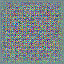

[73/1000][0/37]	Loss_D: 2.9971	Loss_G: 0.2162	D(x): 0.7355	D(G(z)): 0.9208 / 0.9208
[73/1000][25/37]	Loss_D: 2.7596	Loss_G: 0.2218	D(x): 0.7958	D(G(z)): 0.9077 / 0.9077


Exception ignored in: <function _releaseLock at 0x7f9f15c0b830>
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


KeyboardInterrupt: ignored

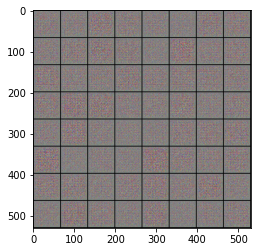

In [13]:

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs=1000
monitor=False
def Normalization(fake):
    for i in range(0,3):
        fake[i]=(fake[i]-fake[i].min())/(fake[i].max()-fake[i].min())
    return fake

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        k=torch.rand(1)
        #Update Discr
        
        if k<0.001:    #train discr
          for n in range(0,100):
            netD.zero_grad()
            #real
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            output = netD(real_cpu).view(-1)
            errD_real = BCEsmooth(output, label)
            errD_real.backward()
            D_x = output.mean().item()
            #fake
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            e=time.time()
            fake = netG(noise)
            label.fill_(fake_label)
            output = netD(fake.detach()).view(-1)
            errD_fake = BCEsmooth(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()

        if k<0.93:
          netD.zero_grad()
          #real
          real_cpu = data[0].to(device)
          b_size = real_cpu.size(0)
          label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
          output = netD(real_cpu).view(-1)
          errD_real = BCEsmooth(output, label)
          errD_real.backward()
          D_x = output.mean().item()
          #fake
          noise = torch.randn(b_size, nz, 1, 1, device=device)
          e=time.time()
          fake = netG(noise)
          label.fill_(fake_label)
          output = netD(fake.detach()).view(-1)
          errD_fake = BCEsmooth(output, label)
          errD_fake.backward()
          D_G_z1 = output.mean().item()
          errD = errD_real + errD_fake
          optimizerD.step()
        else :
          netD.zero_grad()
          #real
          real_cpu = data[0].to(device)
          b_size = real_cpu.size(0)
          label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
          output = netD(real_cpu).view(-1)
          errD_real = BCEsmooth(output, label)
          errD_real.backward()
          D_x = output.mean().item()
          #fake
          noise = torch.randn(b_size, nz, 1, 1, device=device)
          e=time.time()
          fake = netG(noise)
          label.fill_(real_label)
          output = netD(fake.detach()).view(-1)
          errD_fake = BCEsmooth(output, label)
          errD_fake.backward()
          D_G_z1 = output.mean().item()
          errD = errD_real + errD_fake
          optimizerD.step()


        if k<0.0001:
          for n in range(0,100):
            #Update Gen
            netG.zero_grad()
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            label.fill_(real_label) # fake labels are real for generator cost
            fake = netG(noise)  
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            errG = BCEsmooth(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()
        else :
          #Update Gen
          netG.zero_grad()
          label.fill_(real_label)  # fake labels are real for generator cost
          # Since we just updated D, perform another forward pass of all-fake batch through D
          output = netD(fake).view(-1)
          errG = BCEsmooth(output, label)
          errG.backward()
          D_G_z2 = output.mean().item()
          optimizerG.step()




        # Output training stats
        if i % 25 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            
            with torch.no_grad():
              clear_output(wait=True)
              f_noise = torch.randn(1, nz, 1, 1, device=device)
              fake = netG(f_noise).detach().cpu()
            faken=Normalization(fake[0])
            display(array_to_img(np.transpose(faken,(1,2,0))))

        iters += 1        
    
    if epoch%4==0 :
      with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
      img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
      torch.save(netD.state_dict(), os.path.join(dataroot,"netD"+str(epoch)+".pth"))
      torch.save(netG.state_dict(), os.path.join(dataroot,"netG"+str(epoch)+".pth"))
      plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True).cpu(),(1,2,0)))
      plt.savefig("grid_"+str(epoch)+".png")

In [ ]:
torch.rand(1)[0]

In [ ]:
plt.plot(range(0,len(G_losses)),G_losses,color='red')
plt.plot(range(0,len(G_losses)),D_losses)

In [ ]:
range(0,1000,4)[2]

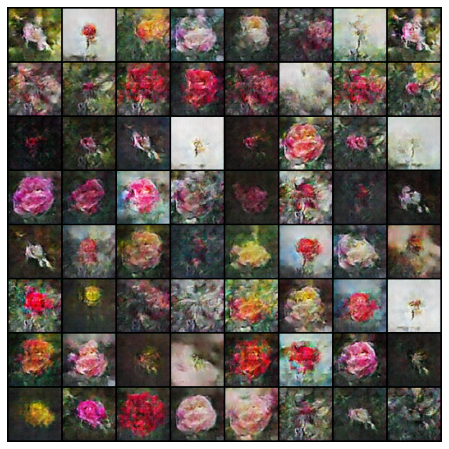

In [11]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list[0:len(img_list):5]]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
def Normalization(fake):
    for i in range(0,3):
        fake[i]=(fake[i]-fake[i].min())/(fake[i].max()-fake[i].min())
    return fake
f_noise = torch.randn(1, nz, 1, 1, device=device)
fake = netG(f_noise).detach().cpu()
faken=Normalization(fake[0])
plt.imshow(np.transpose(faken,(1,2,0)))

In [ ]:
torch.save(netG.state_dict(), os.path.join(dataroot,"netG.pth"))

In [ ]:
torch.save(netD.state_dict(), os.path.join(dataroot,"netD.pth"))
torch.save(netG.state_dict(), os.path.join(dataroot,"netG.pth"))

In [ ]:
netG.load_state_dict(torch.load(os.path.join(dataroot,"netG796.pth")))
netD.load_state_dict(torch.load(os.path.join(dataroot,"netD796.pth")))

In [ ]:
for k in range (0,10):
    f_noise = torch.randn(1, nz, 1, 1, device=device)
    fake = netG(f_noise).detach().cpu()
    def Normalization(fake):
        for i in range(0,3):
            fake[i]=(fake[i]-fake[i].min())/(fake[i].max()-fake[i].min())
        return fake
    faken=Normalization(fake[0])
    plt.imshow(np.transpose(faken,(1,2,0)))